# All Results


In [2]:
import numpy as np

import umap

import torch
import json
import os
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from sklearn.decomposition import PCA

In [3]:
def get_layer_activations(internal_reps, layer_idx):
    """
    Get the activations of a specific layer for all problems and all examples.

    internal_reps: list[tuple[tensor]] where internal_reps[question_num][layer_num]
     is a tensor of shape [batch=1, num_tokens, d_model=4096]

    We will return a tensor of shape [num_questions, num_tokens, d_model=4096]
    for the given layer
    """
    return torch.cat([internal_reps[i][layer_idx] for i in range(len(internal_reps))])


## x + y UMAP 20240709

```bash
# 100 instances, 10 possible answers 15-20
python3 compute_minute_math_reps.py \
    --output_dir results/xyUMAP20240709 \
    --problem_type xy

# 10,000 instances, 10 possible answers 15-20
python3 compute_minute_math_reps.py \
    --output_dir results/xy10kUMAP20240709 \
    --problem_type xy \
    --num_unique_problems 10000

# 1,000 instances
python3 compute_minute_math_reps.py \
    --output_dir results/xy1kUMAP20240709 \
    --problem_type xy \
    --num_unique_problems 1000


```

In [4]:
# Define the directory containing the results
results_dir = 'xyUMAP20240709_cam'

In [5]:
# Load the answers and problems files
answers = np.load(os.path.join(results_dir, 'answers.npy'))
problems = np.load(os.path.join(results_dir, 'problems.npy'))

# Load the internal representations and logits
internal_reps = torch.load(os.path.join(results_dir, 'internal_reps.pt'))
logits = torch.load(os.path.join(results_dir, 'logits.pt'))

# Load the arguments
with open(os.path.join(results_dir, 'args.json'), 'r') as f:
    args = json.load(f)

# Display the shapes and types of the loaded data
print("Answers shape:", answers.shape)
print("Problems shape:", problems.shape)
print("Internal Reps type:", type(internal_reps))
print("Internal Reps length:", len(internal_reps))
print("Logits type:", type(logits))
print("Logits length:", len(logits))

# Let's inspect the internal representations and logits a bit more closely
print("Example internal representation shape:", internal_reps[0][0][0].shape)
print("Example logits shape:", logits[0].shape)

# Display some examples from the loaded data
print("\nExample answers:", answers[0])
print("\nExample problems:", problems[0])
print("\nExample internal representation:", internal_reps[0][0][0])
print("\nExample logits:", logits[0])



/home/user/understanding_understanding/venv/lib/python3.8/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Answers shape: (100, 1)
Problems shape: (100, 17)
Internal Reps type: <class 'list'>
Internal Reps length: 100
Logits type: <class 'torch.Tensor'>
Logits length: 100
Example internal representation shape: torch.Size([17, 4096])
Example logits shape: torch.Size([17, 128256])

Example answers: [868]

Example problems: [128000     87    284    220     22     11    379    284    220     23
     26   9093    865    489    379    284    220]

Example internal representation: tensor([[-8.2970e-05,  2.5749e-04, -2.4605e-04,  ..., -3.2425e-04,
         -2.1553e-04,  4.7112e-04],
        [-2.0752e-03, -1.4038e-03,  6.1035e-03,  ...,  2.2888e-03,
          6.1951e-03,  1.1414e-02],
        [ 1.0376e-03, -6.8054e-03,  6.2943e-04,  ...,  2.5482e-03,
         -8.3618e-03, -8.8501e-03],
        ...,
        [ 3.3569e-03, -3.3760e-04,  2.4719e-03,  ..., -8.3008e-03,
          3.2654e-03, -7.3242e-03],
        [ 1.0376e-03, -6.8054e-03,  6.2943e-04,  ...,  2.5482e-03,
         -8.3618e-03, -8.8501e-03]

### Check correctness of model predictions

In [5]:
# compute the actual token-wise answers
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained(args['model_name'])

# find the argmax over the logits for each 
# problem to get the predicted class

# logits has shape [num_questions, num_tokens, vocab_size]

final_logits = logits[:, -1, :]

# take the argmax over the final dim
predicted_class = torch.argmax(final_logits, dim=1)

# decode each prediction individually
predicted_class_str = [tokenizer.decode(i) for i in predicted_class]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [6]:
str_answers = [tokenizer.decode(i) for i in answers[:, 0]]

str_problems = []
for i in range(problems.shape[0]):
    str_problems.append(tokenizer.decode(problems[i, :]).replace('\n', ' '))

num_correct = 0
for i in range(len(str_answers)):
    if str_answers[i] == predicted_class_str[i]:
        num_correct += 1

num_correct / len(str_answers)

1.0

In [7]:
str_problems

['<|begin_of_text|>x = 7, y = 8; therefore x + y = ',
 '<|begin_of_text|>x = 11, y = 5; therefore x + y = ',
 '<|begin_of_text|>x = 3, y = 14; therefore x + y = ',
 '<|begin_of_text|>x = 12, y = 6; therefore x + y = ',
 '<|begin_of_text|>x = 15, y = 4; therefore x + y = ',
 '<|begin_of_text|>x = 14, y = 6; therefore x + y = ',
 '<|begin_of_text|>x = 2, y = 19; therefore x + y = ',
 '<|begin_of_text|>x = 20, y = 2; therefore x + y = ',
 '<|begin_of_text|>x = 0, y = 23; therefore x + y = ',
 '<|begin_of_text|>x = 17, y = 7; therefore x + y = ',
 '<|begin_of_text|>x = 1, y = 24; therefore x + y = ',
 '<|begin_of_text|>x = 9, y = 6; therefore x + y = ',
 '<|begin_of_text|>x = 8, y = 8; therefore x + y = ',
 '<|begin_of_text|>x = 0, y = 17; therefore x + y = ',
 '<|begin_of_text|>x = 10, y = 8; therefore x + y = ',
 '<|begin_of_text|>x = 6, y = 13; therefore x + y = ',
 '<|begin_of_text|>x = 7, y = 13; therefore x + y = ',
 '<|begin_of_text|>x = 6, y = 15; therefore x + y = ',
 '<|begin_of_

In [30]:
# make a set of integer-valued answers
int_answers = [int(a) for a in str_answers]

In [31]:
class_ids = torch.tensor(answers[:, 0])
class_ids.shape

torch.Size([100])

In [24]:

def get_umap(layer_reps, class_ids):
    """ Compute the UMAP of layer_reps, which is a tensor of shape [num_examples, num_tokens, token_dim]
    """
    print("Layer reps shape:", layer_reps.shape)
    print("Layer reps has type:", type(layer_reps))

    class_ids = class_ids.cpu()
    if type(layer_reps) != np.ndarray: 
        layer_reps = layer_reps.cpu()
    
    # Convert to numpy if it's a torch tensor
    if torch.is_tensor(layer_reps):
        layer_reps = layer_reps.detach().cpu().numpy()
    
    # Flatten the last two dimensions
    try:
        num_examples, num_tokens, token_dim = layer_reps.shape
        flattened_reps = layer_reps.reshape(num_examples, num_tokens * token_dim)
    except: 
        assert len(layer_reps.shape) == 2, "Layer reps shape is messed up"
        flattened_reps = layer_reps

    
    # Apply UMAP
    reducer = umap.UMAP(random_state=42)
    umap_embedding = reducer.fit_transform(flattened_reps)
    # print("Output of reduce transform: ", umap_embedding)
    
    return umap_embedding

def get_class_relevance_pca(layer_reps, class_ids):
    """ Compute the PCA of layer_reps, which is a tensor of shape [num_examples, num_tokens, token_dim]
    We are going to compute the PCA which maximizes the variance of class means
    """
    flattened_reps = layer_reps.reshape(layer_reps.shape[0], -1).cpu()
    
    # Calculate class means efficiently
    unique_classes = np.unique(class_ids)
    print("flattened_reps type: ", type(flattened_reps))
    print("flattened_reps device: ", flattened_reps.device)
    print("class_ids type: ", type(class_ids))
    print("class_ids device: ", class_ids.device)
    class_means = np.array([flattened_reps[class_ids == c].mean(axis=0) for c in unique_classes])
    
    # Run PCA on the class means
    pca = PCA()
    pca.fit(class_means)
    
    # Project the original data onto the PCA components
    projected_data = pca.transform(flattened_reps)
    
    return projected_data

from sklearn.decomposition import PCA

def get_pca(layer_reps, class_ids):
    """ Compute the PCA of layer_reps, which is a tensor of shape [num_examples, num_tokens, token_dim]
    """
    # Convert to numpy if it's a torch tensor
    if torch.is_tensor(layer_reps):
        layer_reps = layer_reps.detach().cpu().numpy()
    
    # Flatten the last two dimensions
    num_examples, num_tokens, token_dim = layer_reps.shape
    flattened_reps = layer_reps.reshape(num_examples, num_tokens * token_dim)
    
    # Apply PCA
    pca = PCA(n_components=2)  # You can adjust the number of components as needed
    pca_result = pca.fit_transform(flattened_reps)
    
    return pca_result

def get_class_pca_and_umap(layer_reps, class_ids):
    """ Compute the PCA and UMAP of layer_reps, which is a tensor of shape [num_examples, num_tokens, token_dim]
    """
    pca_result = get_class_relevance_pca(layer_reps, class_ids)

    number_of_class_ids = len(np.unique(class_ids)) - 1

    pca_and_umap_result = get_umap(pca_result[:, 0:number_of_class_ids], class_ids)
    
    return pca_and_umap_result

In [11]:
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots

# for dim_reduction_func in (get_pca, get_umap, get_class_relevance_pca, get_class_pca_and_umap):
for dim_reduction_func in (get_class_pca_and_umap,):
    # iterate through each layer
    num_layers = 33
    purity_by_layer = []
    for layer_num in range(num_layers):
        layer_activations = get_layer_activations(internal_reps, layer_num)
        low_dim_embedding = dim_reduction_func(layer_activations, class_ids)
        
        # Create Plotly figure
        fig = make_subplots(rows=1, cols=1)
        
        # Add scatter plot
        scatter = go.Scatter(
            x=low_dim_embedding[:, 0],
            y=low_dim_embedding[:, 1],
            mode='markers',
            marker=dict(
                size=8,
                color=int_answers,
                colorscale='Viridis',
                showscale=True
            ),
            text=[f"Problem: {prob}<br>Answer: {ans}<br>Predicted: {pred}" 
                for prob, ans, pred in zip(str_problems, str_answers, predicted_class_str)],
            hoverinfo='text'
        )
        
        fig.add_trace(scatter)
        
        # Update layout
        fig.update_layout(
            title=f'{dim_reduction_func.__name__} for Layer {layer_num}',
            xaxis_title='Dim 1',
            yaxis_title='Dim 2',
            width=1000,
            height=800
        )
        
        # Save as interactive HTML
        pio.write_html(fig, file=f'{results_dir}/{dim_reduction_func.__name__}_layer_{layer_num}.html')
        
        # Save as static PNG
        pio.write_image(fig, file=f'{results_dir}/{dim_reduction_func.__name__}_layer_{layer_num}.png')
        
        # Clear the figure to free up memory
        fig.data = []
        fig.layout = {}

flattened_reps type:  <class 'torch.Tensor'>
flattened_reps device:  cpu
class_ids type:  <class 'torch.Tensor'>
class_ids device:  cpu
Layer reps shape: (100, 10)
Layer reps has type: <class 'numpy.ndarray'>


/home/user/understanding_understanding/venv/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


flattened_reps type:  <class 'torch.Tensor'>
flattened_reps device:  cpu
class_ids type:  <class 'torch.Tensor'>
class_ids device:  cpu
Layer reps shape: (100, 10)
Layer reps has type: <class 'numpy.ndarray'>


/home/user/understanding_understanding/venv/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



flattened_reps type:  <class 'torch.Tensor'>
flattened_reps device:  cpu
class_ids type:  <class 'torch.Tensor'>
class_ids device:  cpu
Layer reps shape: (100, 10)
Layer reps has type: <class 'numpy.ndarray'>


/home/user/understanding_understanding/venv/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



flattened_reps type:  <class 'torch.Tensor'>
flattened_reps device:  cpu
class_ids type:  <class 'torch.Tensor'>
class_ids device:  cpu
Layer reps shape: (100, 10)
Layer reps has type: <class 'numpy.ndarray'>


/home/user/understanding_understanding/venv/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



flattened_reps type:  <class 'torch.Tensor'>
flattened_reps device:  cpu
class_ids type:  <class 'torch.Tensor'>
class_ids device:  cpu
Layer reps shape: (100, 10)
Layer reps has type: <class 'numpy.ndarray'>


/home/user/understanding_understanding/venv/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



flattened_reps type:  <class 'torch.Tensor'>
flattened_reps device:  cpu
class_ids type:  <class 'torch.Tensor'>
class_ids device:  cpu
Layer reps shape: (100, 10)
Layer reps has type: <class 'numpy.ndarray'>


/home/user/understanding_understanding/venv/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



flattened_reps type:  <class 'torch.Tensor'>
flattened_reps device:  cpu
class_ids type:  <class 'torch.Tensor'>
class_ids device:  cpu
Layer reps shape: (100, 10)
Layer reps has type: <class 'numpy.ndarray'>


/home/user/understanding_understanding/venv/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



flattened_reps type:  <class 'torch.Tensor'>
flattened_reps device:  cpu
class_ids type:  <class 'torch.Tensor'>
class_ids device:  cpu
Layer reps shape: (100, 10)
Layer reps has type: <class 'numpy.ndarray'>


/home/user/understanding_understanding/venv/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



flattened_reps type:  <class 'torch.Tensor'>
flattened_reps device:  cpu
class_ids type:  <class 'torch.Tensor'>
class_ids device:  cpu
Layer reps shape: (100, 10)
Layer reps has type: <class 'numpy.ndarray'>


/home/user/understanding_understanding/venv/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



flattened_reps type:  <class 'torch.Tensor'>
flattened_reps device:  cpu
class_ids type:  <class 'torch.Tensor'>
class_ids device:  cpu
Layer reps shape: (100, 10)
Layer reps has type: <class 'numpy.ndarray'>


/home/user/understanding_understanding/venv/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



flattened_reps type:  <class 'torch.Tensor'>
flattened_reps device:  cpu
class_ids type:  <class 'torch.Tensor'>
class_ids device:  cpu
Layer reps shape: (100, 10)
Layer reps has type: <class 'numpy.ndarray'>


/home/user/understanding_understanding/venv/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



flattened_reps type:  <class 'torch.Tensor'>
flattened_reps device:  cpu
class_ids type:  <class 'torch.Tensor'>
class_ids device:  cpu
Layer reps shape: (100, 10)
Layer reps has type: <class 'numpy.ndarray'>


/home/user/understanding_understanding/venv/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



flattened_reps type:  <class 'torch.Tensor'>
flattened_reps device:  cpu
class_ids type:  <class 'torch.Tensor'>
class_ids device:  cpu
Layer reps shape: (100, 10)
Layer reps has type: <class 'numpy.ndarray'>


/home/user/understanding_understanding/venv/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



flattened_reps type:  <class 'torch.Tensor'>
flattened_reps device:  cpu
class_ids type:  <class 'torch.Tensor'>
class_ids device:  cpu
Layer reps shape: (100, 10)
Layer reps has type: <class 'numpy.ndarray'>


/home/user/understanding_understanding/venv/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



flattened_reps type:  <class 'torch.Tensor'>
flattened_reps device:  cpu
class_ids type:  <class 'torch.Tensor'>
class_ids device:  cpu
Layer reps shape: (100, 10)
Layer reps has type: <class 'numpy.ndarray'>


/home/user/understanding_understanding/venv/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



flattened_reps type:  <class 'torch.Tensor'>
flattened_reps device:  cpu
class_ids type:  <class 'torch.Tensor'>
class_ids device:  cpu
Layer reps shape: (100, 10)
Layer reps has type: <class 'numpy.ndarray'>


/home/user/understanding_understanding/venv/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



flattened_reps type:  <class 'torch.Tensor'>
flattened_reps device:  cpu
class_ids type:  <class 'torch.Tensor'>
class_ids device:  cpu
Layer reps shape: (100, 10)
Layer reps has type: <class 'numpy.ndarray'>


/home/user/understanding_understanding/venv/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



flattened_reps type:  <class 'torch.Tensor'>
flattened_reps device:  cpu
class_ids type:  <class 'torch.Tensor'>
class_ids device:  cpu
Layer reps shape: (100, 10)
Layer reps has type: <class 'numpy.ndarray'>


/home/user/understanding_understanding/venv/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



flattened_reps type:  <class 'torch.Tensor'>
flattened_reps device:  cpu
class_ids type:  <class 'torch.Tensor'>
class_ids device:  cpu
Layer reps shape: (100, 10)
Layer reps has type: <class 'numpy.ndarray'>


/home/user/understanding_understanding/venv/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



flattened_reps type:  <class 'torch.Tensor'>
flattened_reps device:  cpu
class_ids type:  <class 'torch.Tensor'>
class_ids device:  cpu
Layer reps shape: (100, 10)
Layer reps has type: <class 'numpy.ndarray'>


/home/user/understanding_understanding/venv/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



flattened_reps type:  <class 'torch.Tensor'>
flattened_reps device:  cpu
class_ids type:  <class 'torch.Tensor'>
class_ids device:  cpu
Layer reps shape: (100, 10)
Layer reps has type: <class 'numpy.ndarray'>


/home/user/understanding_understanding/venv/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



flattened_reps type:  <class 'torch.Tensor'>
flattened_reps device:  cpu
class_ids type:  <class 'torch.Tensor'>
class_ids device:  cpu
Layer reps shape: (100, 10)
Layer reps has type: <class 'numpy.ndarray'>


/home/user/understanding_understanding/venv/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



flattened_reps type:  <class 'torch.Tensor'>
flattened_reps device:  cpu
class_ids type:  <class 'torch.Tensor'>
class_ids device:  cpu
Layer reps shape: (100, 10)
Layer reps has type: <class 'numpy.ndarray'>


/home/user/understanding_understanding/venv/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



flattened_reps type:  <class 'torch.Tensor'>
flattened_reps device:  cpu
class_ids type:  <class 'torch.Tensor'>
class_ids device:  cpu
Layer reps shape: (100, 10)
Layer reps has type: <class 'numpy.ndarray'>


/home/user/understanding_understanding/venv/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



flattened_reps type:  <class 'torch.Tensor'>
flattened_reps device:  cpu
class_ids type:  <class 'torch.Tensor'>
class_ids device:  cpu
Layer reps shape: (100, 10)
Layer reps has type: <class 'numpy.ndarray'>


/home/user/understanding_understanding/venv/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



flattened_reps type:  <class 'torch.Tensor'>
flattened_reps device:  cpu
class_ids type:  <class 'torch.Tensor'>
class_ids device:  cpu
Layer reps shape: (100, 10)
Layer reps has type: <class 'numpy.ndarray'>


/home/user/understanding_understanding/venv/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



flattened_reps type:  <class 'torch.Tensor'>
flattened_reps device:  cpu
class_ids type:  <class 'torch.Tensor'>
class_ids device:  cpu
Layer reps shape: (100, 10)
Layer reps has type: <class 'numpy.ndarray'>


/home/user/understanding_understanding/venv/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



flattened_reps type:  <class 'torch.Tensor'>
flattened_reps device:  cpu
class_ids type:  <class 'torch.Tensor'>
class_ids device:  cpu
Layer reps shape: (100, 10)
Layer reps has type: <class 'numpy.ndarray'>


/home/user/understanding_understanding/venv/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



flattened_reps type:  <class 'torch.Tensor'>
flattened_reps device:  cpu
class_ids type:  <class 'torch.Tensor'>
class_ids device:  cpu
Layer reps shape: (100, 10)
Layer reps has type: <class 'numpy.ndarray'>


/home/user/understanding_understanding/venv/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



flattened_reps type:  <class 'torch.Tensor'>
flattened_reps device:  cpu
class_ids type:  <class 'torch.Tensor'>
class_ids device:  cpu
Layer reps shape: (100, 10)
Layer reps has type: <class 'numpy.ndarray'>


/home/user/understanding_understanding/venv/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



flattened_reps type:  <class 'torch.Tensor'>
flattened_reps device:  cpu
class_ids type:  <class 'torch.Tensor'>
class_ids device:  cpu
Layer reps shape: (100, 10)
Layer reps has type: <class 'numpy.ndarray'>


/home/user/understanding_understanding/venv/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



flattened_reps type:  <class 'torch.Tensor'>
flattened_reps device:  cpu
class_ids type:  <class 'torch.Tensor'>
class_ids device:  cpu
Layer reps shape: (100, 10)
Layer reps has type: <class 'numpy.ndarray'>


/home/user/understanding_understanding/venv/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



flattened_reps type:  <class 'torch.Tensor'>
flattened_reps device:  cpu
class_ids type:  <class 'torch.Tensor'>
class_ids device:  cpu
Layer reps shape: (100, 10)
Layer reps has type: <class 'numpy.ndarray'>


/home/user/understanding_understanding/venv/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [12]:
# # iterate through each layer
# num_layers = 33
# purity_by_layer = []
# for layer_num in range(num_layers):
#     layer_activations = get_layer_activations(internal_reps, layer_num)
#     umap_embedding = get_umap(layer_activations)
    
#     # Plot UMAP
#     plt.figure(figsize=(10, 8))
#     scatter = plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=int_answers, cmap='viridis')
#     plt.colorbar(scatter)
#     plt.title(f'UMAP for Layer {layer_num}')
#     plt.savefig(f'{results_dir}/umap_layer_{layer_num}.png')
#     plt.close()
    

In [13]:
type(answers)

numpy.ndarray

In [14]:
model = AutoModelForCausalLM.from_pretrained("meta-llama/Meta-Llama-3-8B-Instruct", device_map='auto')

Loading checkpoint shards: 100%|██████████| 4/4 [00:13<00:00,  3.36s/it]


In [15]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
  (lm_head)

In [16]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
  (lm_head)

In [17]:
layer_activations

tensor([[[ 4.1851, -0.2059, -1.8382,  ..., -2.8908,  1.3605,  0.3109],
         [ 1.2942, -4.6553,  0.2416,  ...,  2.4082,  0.4292, -1.4888],
         [ 1.6030, -0.9961,  2.2922,  ...,  1.3186, -0.8656, -1.0692],
         ...,
         [-0.6426,  2.8010,  4.5676,  ..., -0.4665,  0.7432, -2.6349],
         [-1.4301,  0.0569,  2.6330,  ...,  1.0594,  0.2765, -3.0647],
         [-2.4644, -3.2000,  1.7012,  ..., -1.0187,  1.5276,  1.0285]],

        [[ 4.1851, -0.2059, -1.8382,  ..., -2.8908,  1.3605,  0.3109],
         [ 1.2942, -4.6553,  0.2416,  ...,  2.4082,  0.4292, -1.4888],
         [ 1.6030, -0.9961,  2.2922,  ...,  1.3186, -0.8656, -1.0692],
         ...,
         [-1.1591,  3.2138,  3.5799,  ..., -0.2368,  0.2975, -3.6477],
         [-1.3349, -0.3476,  2.1352,  ...,  1.3411,  0.0254, -4.7679],
         [-0.4112, -3.9738,  3.0329,  ...,  0.5366,  2.0905, -0.1498]],

        [[ 4.1851, -0.2059, -1.8382,  ..., -2.8908,  1.3605,  0.3109],
         [ 1.2942, -4.6553,  0.2416,  ...,  2

In [18]:
normed_activations = model.model.norm(layer_activations)

In [19]:
layer_activations.shape

torch.Size([100, 17, 4096])

## Testing if the last hidden state gives the logits

In [20]:
model.device

device(type='cuda', index=0)

In [21]:
input_string= "Hello, my name is Albert Einstein, and I am a physicist."
input_ids = tokenizer(input_string, return_tensors='pt')['input_ids'].to(model.device)

# run thru model, grab logits and hidden states and last_hidden_states
outputs = model(input_ids, output_hidden_states=True, return_dict=True)
logits = outputs.logits
hidden_states = outputs.hidden_states
last_hidden_state = hidden_states[-1]

# print the shapes of each 
print("Input ids shape: ", input_ids.shape)
print("Logits shape: ", logits.shape)
print("Hidden states shapes: ", [hs.shape for hs in hidden_states])
print("Last hidden state shape: ", last_hidden_state.shape)


We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


Input ids shape:  torch.Size([1, 15])
Logits shape:  torch.Size([1, 15, 128256])
Hidden states shapes:  [torch.Size([1, 15, 4096]), torch.Size([1, 15, 4096]), torch.Size([1, 15, 4096]), torch.Size([1, 15, 4096]), torch.Size([1, 15, 4096]), torch.Size([1, 15, 4096]), torch.Size([1, 15, 4096]), torch.Size([1, 15, 4096]), torch.Size([1, 15, 4096]), torch.Size([1, 15, 4096]), torch.Size([1, 15, 4096]), torch.Size([1, 15, 4096]), torch.Size([1, 15, 4096]), torch.Size([1, 15, 4096]), torch.Size([1, 15, 4096]), torch.Size([1, 15, 4096]), torch.Size([1, 15, 4096]), torch.Size([1, 15, 4096]), torch.Size([1, 15, 4096]), torch.Size([1, 15, 4096]), torch.Size([1, 15, 4096]), torch.Size([1, 15, 4096]), torch.Size([1, 15, 4096]), torch.Size([1, 15, 4096]), torch.Size([1, 15, 4096]), torch.Size([1, 15, 4096]), torch.Size([1, 15, 4096]), torch.Size([1, 15, 4096]), torch.Size([1, 15, 4096]), torch.Size([1, 15, 4096]), torch.Size([1, 15, 4096]), torch.Size([1, 15, 4096]), torch.Size([1, 15, 4096])]
Last

In [22]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
  (lm_head)

In [23]:
approx_logits = model.lm_head(last_hidden_state)

In [24]:
approx_logits.shape

torch.Size([1, 15, 128256])

In [25]:
logits.shape

torch.Size([1, 15, 128256])

In [26]:
# check if logits are all close
torch.allclose(logits, approx_logits)

True

In [27]:
last_hidden_state - hidden_states[-1]
# check if all close
torch.allclose(last_hidden_state, hidden_states[-1])

True

In [28]:
approx2_logits = model.lm_head(hidden_states[-1])
# check if all close
torch.allclose(logits, approx2_logits)

True

tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)


Text(0.5, 1.0, 'Lipschitz Ratios for Each Layer')

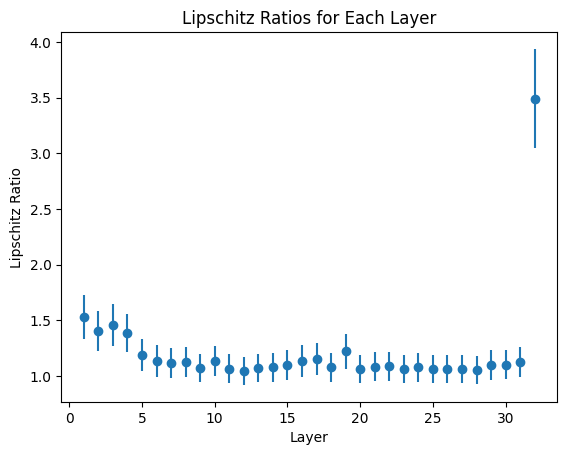

In [18]:
# For each layer of the model, we are going to take the embedding of the 0th element (flattened)
# Then, we are going to compute its distance from the 10th, 20th, 30th, etc. elements
# We will then plot this distance as a function of the layer number
# Plot all of this on a single plot, where each line is labelled by "x + y = z", but instead of x and y, it will be the corresponding values from str_problems
num_layers = 33
layer_activations_0 = get_layer_activations(internal_reps, 0)
num_examples, num_tokens, token_dim = layer_activations_0.shape
distances = torch.zeros((num_layers, num_examples, num_examples))
for layer_num in range(num_layers):
        layer_activations = get_layer_activations(internal_reps, layer_num)

        # Flatten the last two dimensions
        num_examples, num_tokens, token_dim = layer_activations.shape
        flattened_reps = layer_activations.reshape(num_examples, num_tokens * token_dim)

        # normalize flattened_reps
        # flattened_reps = F.normalize(flattened_reps, p=2, dim=1)

        # Compute the pairwise distance between each pair of examples
        distances[layer_num] = (flattened_reps[:, None, :] - flattened_reps[None, :, :]).norm(p=2, dim=-1)
        
# Compute Lipschitz ratios for each layer_i -> layer_i+1
# Compute Lipschitz ratios for each layer_i -> layer_i+1
lipschitz_ratio_mean = []
lipschitz_ration_std = []
for i in range(num_layers - 1):
    dist_ratio = distances[i+1] / (distances[i]+1e-6)
    dist_ratio[torch.diag(torch.ones(num_examples)).bool()] = 0
    lipschitz_ratio_mean += [torch.mean(dist_ratio).item()]
    lipschitz_ration_std += [torch.std(dist_ratio).item()]
    print(torch.sum(torch.tensor(lipschitz_ratio_mean)< 1.0))

# Plot the Lipschitz ratio mean, then plot error as shaded region at 1, 2 standard deviations.
plt.errorbar(range(1, num_layers), lipschitz_ratio_mean, yerr=[lipschitz_ration_std, lipschitz_ration_std], fmt='o')
plt.xlabel('Layer')
plt.ylabel('Lipschitz Ratio')
plt.title('Lipschitz Ratios for Each Layer')
